In [1]:
import keras
import cv2
from skimage.transform import rotate
import os
import itertools
import numpy as np
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
INPUT_SHAPE = (96, 96, 3)
IM_HEIGHT = 96
IM_WIDTH = 96
OUTPUT_SIZE = 2

LEARNING_RATE = 0.0005
OPTIMIZER = keras.optimizers.Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

SL_TRAIN_SIZE = 40016
SL_VALIDATION_SIZE = 9634
SL_TEST_SIZE = 13037
BKG_TEST_SIZE = 277390
EPOCHS = 30
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50
STEPS_PER_EPOCH = (2 * SL_TRAIN_SIZE) // BATCH_SIZE + 1
VALIDATION_STEPS_PER_EPOCH = (2 * SL_VALIDATION_SIZE) // BATCH_SIZE + 1
MAX_EPOCHS_WITH_SAME_DATA_SET = 20
TEST_STEPS = (SL_TEST_SIZE + BKG_TEST_SIZE) // BATCH_SIZE + 1

TRAIN_PATH = "./data_set/train/"
VALIDATION_PATH = "./data_set/validation/"
TEST_PATH = "./data_set/test/"

MODEL_PATH = "./binary_classifier/net_2_model.h5"

MR_CKPT_PATH = "./binary_classifier/net_2_most_recent_checkpoint.hdf5"
CB_CKPT_PATH = "./binary_classifier/net_2_current_best_checkpoint.hdf5"

In [4]:
# Load model

model = keras.models.load_model(MODEL_PATH)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]


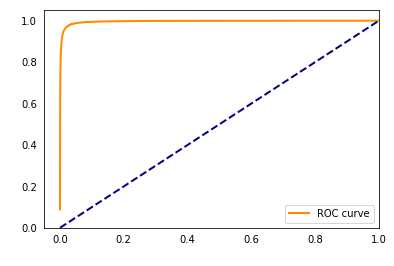

In [5]:
# Plot ROC

lst = []
Y_pred = []
Y_pred_prob = []
Y_roc_true = []
tmp = os.listdir(TEST_PATH + '0_sea_lions')
for elem in tmp:
    lst.append(list((TEST_PATH + '0_sea_lions/' + elem, 'sea_lion')))
tmp = os.listdir(TEST_PATH + '1_background')
for elem in tmp:
    lst.append(list((TEST_PATH + '1_background/' + elem, 'background')))
for elem in lst:
    img = cv2.imread(elem[0])
    X = np.reshape(img_to_array(img), (1, 96, 96, 3))
    X.astype('float32')
    X /= 255
    if elem[1] == 'sea_lion':
        expected_class = [1, 0]
    else:
        expected_class = [0, 1]
    prediction = model.predict(X, batch_size=1)
    if prediction[0][0] > prediction[0][1]:
        predicted_class = [1, 0]
    else:
        predicted_class = [0, 1]
    Y_pred = Y_pred + [predicted_class[0]]
    Y_pred_prob = Y_pred_prob + [prediction[0][0]]
    Y_roc_true = Y_roc_true + [expected_class[0]]

Y_pred = np.array(Y_pred)
Y_pred_prob = np.array(Y_pred_prob)
Y_roc_true = np.array(Y_roc_true)
print(Y_pred)
print(Y_roc_true)

fpr, tpr, _ = metrics.roc_curve(Y_roc_true, Y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.tick_params(which='both', color='white')
plt.legend(loc='lower right')
plt.show()

In [6]:
# Evaluate AUC of the ROC
metrics.roc_auc_score(Y_roc_true, Y_pred_prob)

0.9964185506533891

True positives 12735
False positives 7632
True negatives 269758
False negatives 302




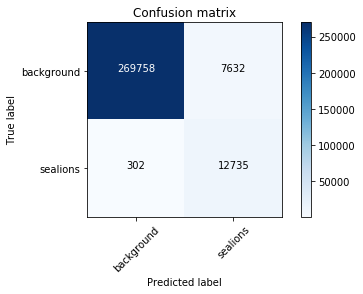



Sea lions: 
Precision   0.6253, Recall   0.9768

Background: 
Precision   0.9989, Recall   0.9725

Accuracy:   0.9727


In [7]:
#Compute precision and recall

tn, fp, fn, tp = confusion_matrix(Y_roc_true, Y_pred).ravel()
c = confusion_matrix(Y_roc_true, Y_pred)
            
sea_lion_prec = tp / (tp + fp)
sea_lion_reca = tp / (tp + fn)
background_prec = tn / (tn + fn)
background_reca = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print('True positives %d' % (tp))
print('False positives %d' % (fp))
print('True negatives %d' % (tn))
print('False negatives %d\n\n' % (fn))
plot_confusion_matrix(c, ['background', 'sealions'])
print('\n\nSea lions: \nPrecision %8.4f, Recall %8.4f' % (sea_lion_prec, sea_lion_reca))
print('\nBackground: \nPrecision %8.4f, Recall %8.4f' % (background_prec, background_reca))
print('\nAccuracy: %8.4f' % (accuracy))

Text(0.5,1,'2-class Precision-Recall curve: AP=0.96')

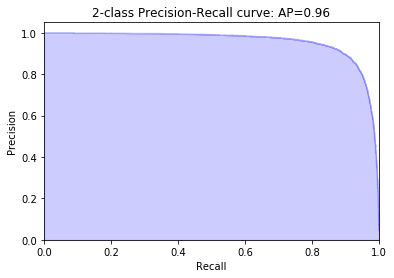

In [8]:
#Plot precision-recall curve 

average_precision = average_precision_score(Y_roc_true, Y_pred_prob)
precision, recall, _ = precision_recall_curve(Y_roc_true, Y_pred_prob)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [9]:
# Free memory

X_test = []
Y_test = []

True positives 12735
False positives 364
True negatives 12673
False negatives 302




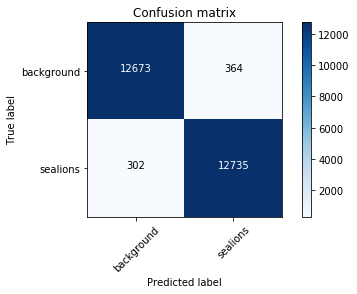



Sea lions: 
Precision   0.9722, Recall   0.9768

Background: 
Precision   0.9767, Recall   0.9721

Accuracy:   0.9745


In [10]:
# Save wrong predicted patches

lst = []
wrong_lst = []
Y_pred_bal = []
Y_pred_prob_bal = []
Y_roc_true_bal = []
tmp = os.listdir(TEST_PATH + '0_sea_lions')
for elem in tmp:
    lst.append(list((TEST_PATH + '0_sea_lions/' + elem, 'sea_lion')))
tmp = rand.sample(os.listdir(TEST_PATH + '1_background'), SL_TEST_SIZE)
for elem in tmp:
    lst.append(list((TEST_PATH + '1_background/' + elem, 'background')))
for elem in lst:
    img = cv2.imread(elem[0])
    X = np.reshape(img_to_array(img), (1, 96, 96, 3))
    X.astype('float32')
    X /= 255
    if elem[1] == 'sea_lion':
        expected_class = [1, 0]
    else:
        expected_class = [0, 1]
    prediction = model.predict(X, batch_size=1)
    if prediction[0][0] > prediction[0][1]:
        predicted_class = [1, 0]
    else:
        predicted_class = [0, 1]
    Y_pred_bal = Y_pred_bal + [predicted_class[0]]
    Y_pred_prob_bal = Y_pred_prob_bal + [prediction[0][0]]
    Y_roc_true_bal = Y_roc_true_bal + [expected_class[0]]
    if not(expected_class == predicted_class):
        wrong_lst.append(list((elem[0], elem[1], prediction[0][0], prediction[0][1])))

wrong_prediction_df = pd.DataFrame(data=wrong_lst, columns=["image_path", "expected_class", "sl_probability", "bkg_probability"])
wrong_prediction_df.to_csv("./wrong_predictions.csv", index=False)

Y_pred = np.array(Y_pred_bal)
Y_pred_prob = np.array(Y_pred_prob_bal)
Y_roc_true = np.array(Y_roc_true_bal)
tn, fp, fn, tp = confusion_matrix(Y_roc_true_bal, Y_pred_bal).ravel()
c = confusion_matrix(Y_roc_true, Y_pred)
            
sea_lion_prec = tp / (tp + fp)
sea_lion_reca = tp / (tp + fn)
background_prec = tn / (tn + fn)
background_reca = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print('True positives %d' % (tp))
print('False positives %d' % (fp))
print('True negatives %d' % (tn))
print('False negatives %d\n\n' % (fn))
plot_confusion_matrix(c, ['background','sealions'])
print('\n\nSea lions: \nPrecision %8.4f, Recall %8.4f' % (sea_lion_prec, sea_lion_reca))
print('\nBackground: \nPrecision %8.4f, Recall %8.4f' % (background_prec, background_reca))
print('\nAccuracy: %8.4f' % (accuracy))

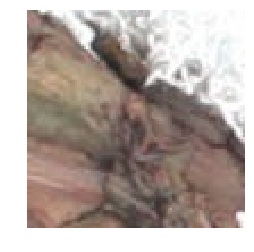

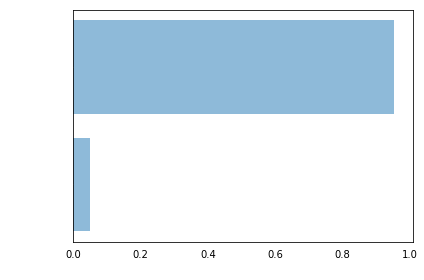

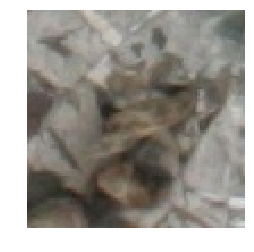

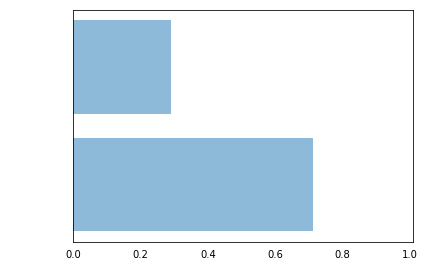

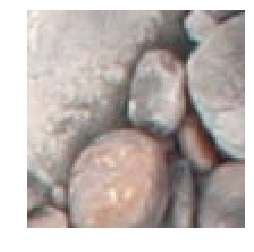

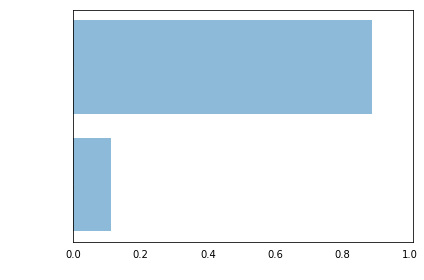

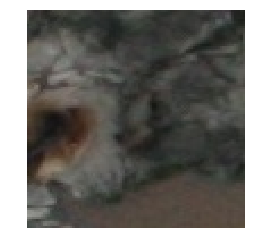

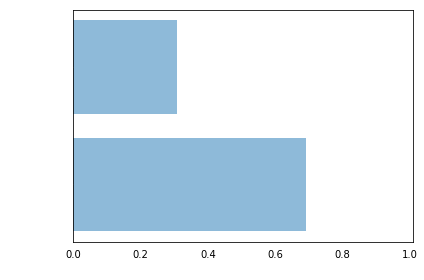

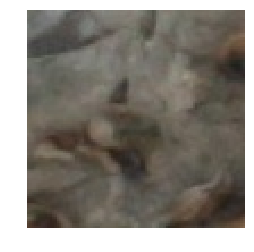

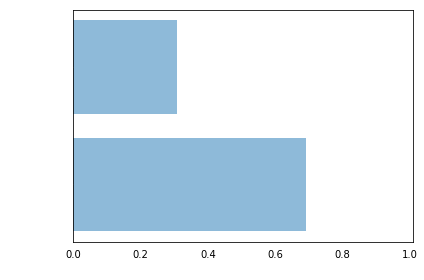

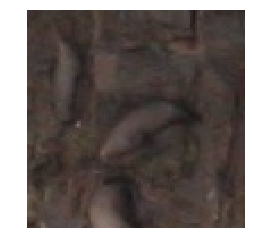

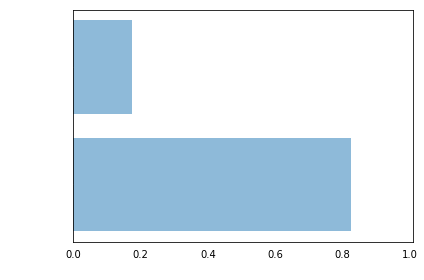

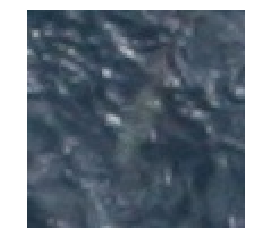

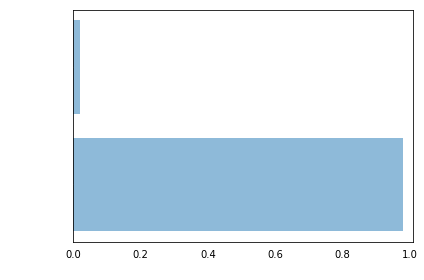

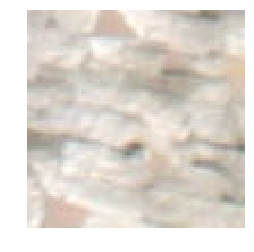

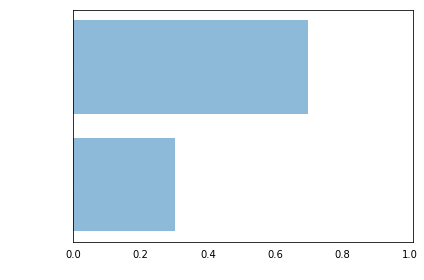

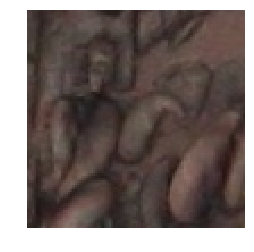

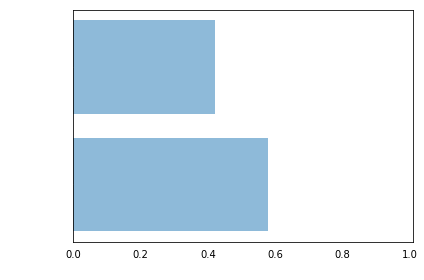

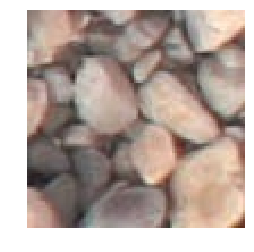

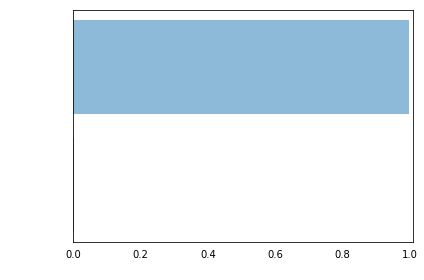

In [11]:
wrong_prediction_df = pd.read_csv("./wrong_predictions.csv")
for row in wrong_prediction_df.sample(10).iterrows():
   
    image = cv2.imread(row[1]['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    preds = [row[1]['sl_probability'], row[1]['bkg_probability']]
    plt.imshow(image)
    plt.axis('off')
    
    plt.figure()
    order = list(reversed(range(len(preds))))
    labels = ['sea lion', 'background']
    plt.barh(order, preds, alpha=0.5)
    plt.yticks(order, labels, color='white')
    plt.xlabel('Probability', color='white')
    plt.xlim(0, 1.01)
    plt.tick_params(which='both', color='white')
    plt.tight_layout()
    plt.show()